In [1]:
from utils.getter import *
import torch.utils.data as data
import torch
from tqdm import tqdm
import torch.nn as nn

In [2]:
transforms = Compose([
    Resize((300,300)),
    ToTensor(),
    Normalize(),
])

In [3]:
data_path = "datasets/datasets/Garbage Classification"
voc_path = "datasets/datasets/VOC/images"
voc_anno = {
    "train": "datasets/datasets/VOC/annotations/pascal_train2012.json",
    "val": "datasets/datasets/VOC/annotations/pascal_val2012.json"}

#trainset = ImageClassificationDataset(data_path+ "/train", transforms= transforms, shuffle=True)
#valset = ImageClassificationDataset(data_path+ "/val", transforms= transforms, shuffle = True)

trainset = ObjectDetectionDataset(img_dir=voc_path, ann_path = voc_anno['train'],transforms= transforms)
valset = ObjectDetectionDataset(img_dir=voc_path, ann_path = voc_anno['val'],transforms= transforms)
NUM_CLASSES = len(trainset.classes)
print(trainset)
print(valset)

Custom Dataset for Object Detection
-------------------------------
Number of samples: 5717
Number of classes: 20

Custom Dataset for Object Detection
-------------------------------
Number of samples: 5823
Number of classes: 20



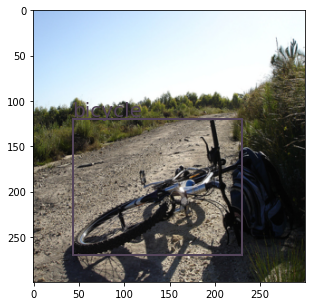

In [4]:
trainset.visualize_item(figsize=(5,5))

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [6]:
from torch.optim.lr_scheduler import StepLR
from models.retinanet.loss import FocalLoss
from models.retinanet.detector import RetinaDetector
from models.retinanet.retina_collator import RetinaNetCollator

In [7]:
BATCH_SIZE = 4
my_collate = RetinaNetCollator() #trainset.collate_fn, valset.collate_fn
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=my_collate, shuffle=True)
valloader = data.DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=my_collate, shuffle=False)


In [8]:
criterion = FocalLoss
optimizer = torch.optim.Adam

model = RetinaDetector(
                n_classes = NUM_CLASSES,
                lr = 1e-3,
                criterion= criterion, 
                optimizer= optimizer,
                device = device)
load_checkpoint(model, "weights/RetinaNet-10.pth")

Loaded Successfully!


In [9]:
trainer = Trainer(model,
                     trainloader, 
                     valloader,
                     clip_grad = 1.0,
                     checkpoint = Checkpoint(save_per_epoch=1),
                     scheduler = StepLR(model.optimizer, step_size=5, gamma=0.5),
                     evaluate_per_epoch = 15)
    
print(trainer)

---------MODEL INFO----------------
Model name: RetinaNet
Number of trainable parameters:  36,133,912
Loss function: FocalLoss
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.00025
    weight_decay: 0
)
Training iterations per epoch: 1430
Validating iterations per epoch: 1456


In [10]:
loc_preds, cls_preds = trainer.inference_batch(valloader)
print(loc_preds[0].shape)
print(cls_preds[0].shape)
results = my_collate.encoder.decode(loc_preds[0],cls_preds[0],300)
print(results)

torch.Size([17451, 4])
torch.Size([17451, 20])


D:\GITHUB\Pytorch-Custom-Template\models\retinanet\encoder.py:123: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  ids = ids.nonzero().squeeze()             # [#obj,]


(tensor([[ 39.7242, 111.0300, 102.0000, 220.0972],
        [201.4410, 213.4097, 232.5789, 267.9434],
        [161.9674,  79.1992, 193.1052, 133.7328],
        ...,
        [151.1904,  19.9237, 203.8850,  51.1417],
        [144.4860, 134.5843, 249.8753, 197.0203],
        [119.6114,  98.8711, 172.3061, 130.0891]]), tensor([14, 14, 14,  ..., 14, 14, 14]))


In [43]:
print(results[1].unique())

tensor([14])


[[39.72418975830078, 111.02996063232422, 101.99996185302734, 220.09722900390625]] [14]


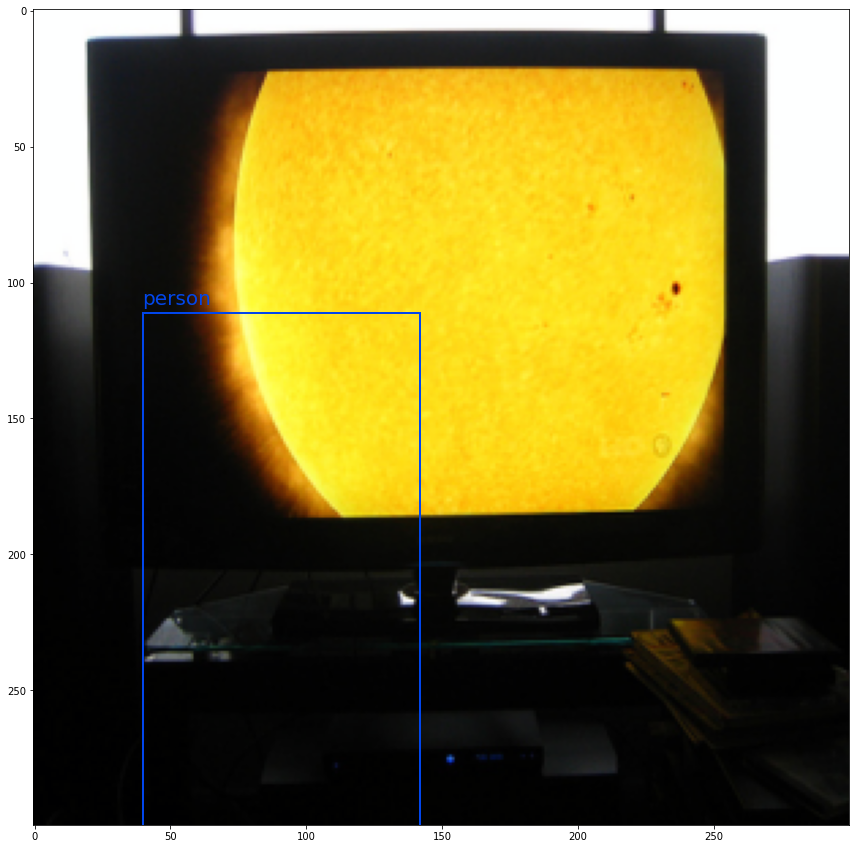

In [40]:
box_test = results[0][0]
label_test = results[1][0]
for batch in valloader:
    img_test = batch['imgs'][0]
    break
s = valset.transforms.denormalize(img = img_test, box = box_test, label = label_test)
img = s['img']
boxes = [s['box'].numpy().tolist()]
label = [s['label'].numpy().tolist()]
print(boxes,label)
valset.visualize(img,boxes,label)

In [ ]:
for idx, batch in enumerate(trainloader):
    optimizer.zero_grad()
    imgs = batch['imgs'].to(device)
    #boxes = [x.to(device) for x in batch['boxes']]
    #labels = [x.to(device) for x in batch['labels']]
    boxes = batch['boxes'].to(device)
    labels = batch['labels'].to(device)
  
    loc_preds, cls_preds = model(imgs)
    loss = criterion(loc_preds, cls_preds, boxes, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if idx % 10 == 0:
        print('[{}/{}] | Loss: {} '.format(idx, len(trainloader), loss.item()))
        #print('[{}/{}] | C: {} | B: {} '.format(idx, len(trainloader), losses['C'].item(), losses['B'].item()))

In [ ]:
for idx, batch in enumerate(trainloader):
    with torch.no_grad():
        imgs = batch['imgs'].to(device)
        boxes = [x.to(device) for x in batch['boxes']]
        labels = [x.to(device) for x in batch['labels']]
        loc_preds, cls_preds = model(imgs)
        det_boxes, det_labels, det_scores = model.detect_objects(
            loc_preds,
            cls_preds,
            min_score=0.01,
            max_overlap=0.45,
            top_k=200)
    break

In [ ]:
print(det_scores)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
metrics = [AccuracyMetric(decimals=3)]

In [ ]:
NUM_CLASSES = len(trainset.classes)
model = ResNet34(NUM_CLASSES,
                 lr = 1e-4,
                 criterion= criterion, 
                 optimizer= optimizer,
                 metrics=  metrics,
                 device = device)
#load_checkpoint(model, "weights/ResNet34-12.pth")

In [ ]:
cp = Checkpoint(save_per_epoch=1)
trainer = Trainer(model,
                 trainloader, 
                 valloader,
                 checkpoint = cp, 
                 evaluate_per_epoch = 1)

trainer.fit(num_epochs=5)

In [ ]:
preds = trainer.inference_batch(valloader)
print(preds)

In [ ]:
idx = 35
print(valset.classes[preds[idx]])
valset.visualize_item(idx, figsize = (8,8))